**Setup: Install & Imports**

In [2]:
!pip -q install kagglehub opencv-python tensorflow seaborn matplotlib scikit-learn

import os, glob, random, itertools, time, json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

import kagglehub
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

np.random.seed(42)
tf.random.set_seed(42)

**Download data**

In [3]:
path = kagglehub.dataset_download("gti-upm/leapgestrecog")
print("Dataset downloaded to:", path)

100%|██████████| 2.13G/2.13G [01:39<00:00, 22.9MB/s]

Extracting files...


Dataset downloaded to: /root/.cache/kagglehub/datasets/gti-upm/leapgestrecog/versions/1


**Discover data**

In [4]:
def discover_images(root):
    """
    Walks the dataset and returns (file_path, class_label) pairs.
    Class label is taken from the gesture directory name like '01_palm'.
    """
    image_paths = []
    class_names = set()

    for person_dir in sorted(glob.glob(os.path.join(root, "*"))):
        if not os.path.isdir(person_dir):
            continue
        for gesture_dir in sorted(glob.glob(os.path.join(person_dir, "*"))):
            if not os.path.isdir(gesture_dir):
                continue
            gesture = os.path.basename(gesture_dir)
            class_names.add(gesture)
            files = glob.glob(os.path.join(gesture_dir, "*.png"))
            for f in files:
                image_paths.append((f, gesture))
    class_names = sorted(list(class_names))
    return image_paths, class_names

In [5]:
candidate = os.path.join(path, "leapGestRecog")
root_dir = candidate if os.path.isdir(candidate) else path

pairs, classes = discover_images(root_dir)
print(f"Discovered {len(pairs)} images across {len(classes)} classes.")
print("Classes:", classes)

label2idx = {c:i for i,c in enumerate(classes)}
idx2label = {i:c for c,i in label2idx.items()}

Discovered 20000 images across 10 classes.
Classes: ['01_palm', '02_l', '03_fist', '04_fist_moved', '05_thumb', '06_index', '07_ok', '08_palm_moved', '09_c', '10_down']


**Class Distribution**

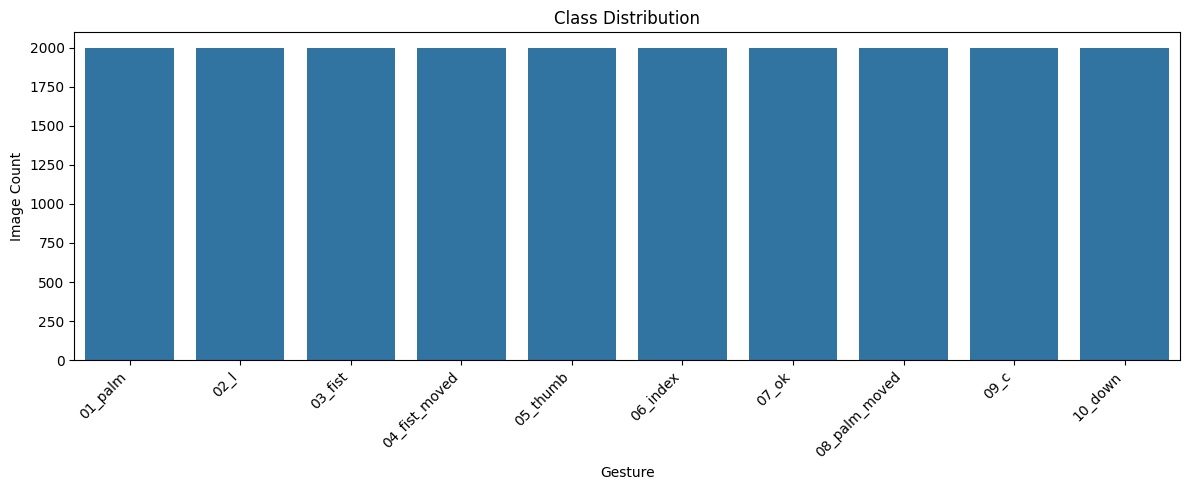

In [6]:
counts = {c:0 for c in classes}
for _, c in pairs:
    counts[c] += 1

plt.figure(figsize=(12,5))
sns.barplot(x=list(counts.keys()), y=list(counts.values()))
plt.xticks(rotation=45, ha='right')
plt.title("Class Distribution")
plt.xlabel("Gesture")
plt.ylabel("Image Count")
plt.tight_layout()
plt.show()

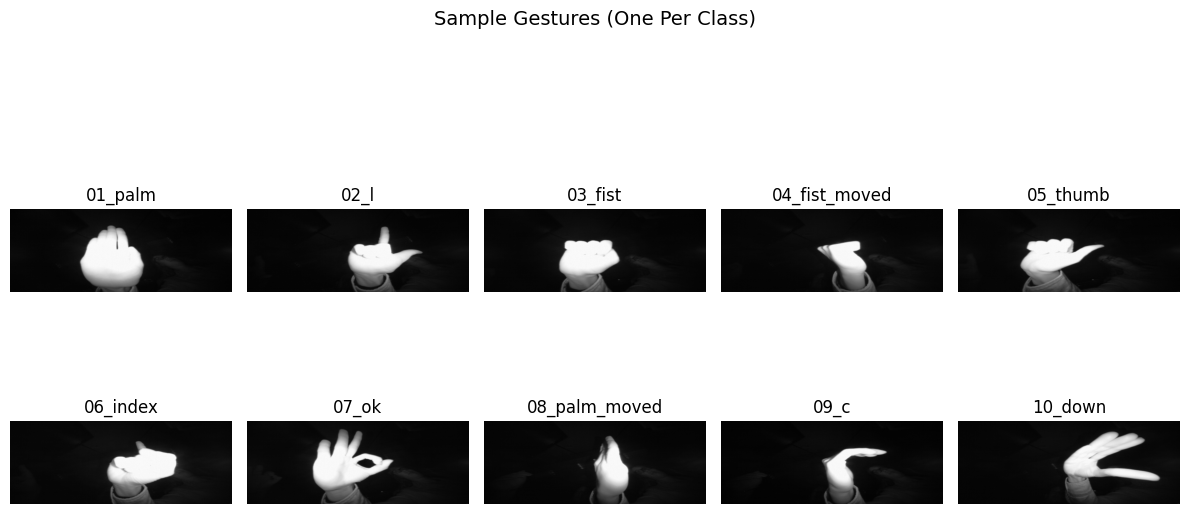

In [7]:
plt.figure(figsize=(12, 6))
for i, c in enumerate(classes[:10]):  # show up to first 10 classes to keep grid readable

    sample_path = next(p for p,label in pairs if label==c)
    img = cv2.imread(sample_path, cv2.IMREAD_GRAYSCALE)
    plt.subplot(2, 5, i+1)
    plt.imshow(img, cmap='gray')
    plt.title(c)
    plt.axis('off')
plt.suptitle("Sample Gestures (One Per Class)", y=1.05, fontsize=14)
plt.tight_layout()
plt.show()

**Data Loading & Preprocessing**

In [8]:
IMG_SIZE = 128

def load_and_preprocess(img_path):

    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:

        img = np.zeros((IMG_SIZE, IMG_SIZE), dtype=np.uint8)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img.astype(np.float32) / 255.0

    img = np.expand_dims(img, axis=-1)  # (H, W, 1)
    return img

In [9]:
all_images = []
all_labels = []

for f, c in pairs:
    all_images.append(load_and_preprocess(f))
    all_labels.append(label2idx[c])

X = np.stack(all_images, axis=0)  # (N, H, W, 1)
y = np.array(all_labels, dtype=np.int64)

print("X shape:", X.shape, "y shape:", y.shape)

X shape: (20000, 128, 128, 1) y shape: (20000,)


**Train/Val/Test split**

In [10]:
X_train, X_tmp, y_train, y_tmp = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_tmp, y_tmp, test_size=0.50, stratify=y_tmp, random_state=42
)

print("Split sizes:", X_train.shape, X_val.shape, X_test.shape)

Split sizes: (14000, 128, 128, 1) (3000, 128, 128, 1) (3000, 128, 128, 1)


**Model Building**

In [11]:
num_classes = len(classes)

def build_model(input_shape=(IMG_SIZE, IMG_SIZE, 1), num_classes=10):
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2,2),

        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2,2),

        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2,2),

        layers.Dropout(0.25),
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.4),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

model = build_model(input_shape=(IMG_SIZE, IMG_SIZE, 1), num_classes=num_classes)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     8,388,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,486,026 (32.37 MB)

 Trainable params: 8,485,066 (32.37 MB)

 Non-trainable params: 960 (3.75 KB)

**Training**

In [12]:


from tensorflow.keras import callbacks

es = callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=3,
    restore_best_weights=True
)

rlr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    verbose=1
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=12,
    batch_size=64,
    callbacks=[es, rlr],
    verbose=1
)


Epoch 1/12
219/219 ━━━━━━━━━━━━━━━━━━━━ 28s 84ms/step - accuracy: 0.8607 - loss: 0.5209 - val_accuracy: 0.1000 - val_loss: 27.1740 - learning_rate: 0.0010
Epoch 2/12
219/219 ━━━━━━━━━━━━━━━━━━━━ 25s 43ms/step - accuracy: 0.9991 - loss: 0.0101 - val_accuracy: 0.2460 - val_loss: 8.5111 - learning_rate: 0.0010
Epoch 3/12
219/219 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - accuracy: 0.9997 - loss: 0.0029 - val_accuracy: 0.8097 - val_loss: 0.4928 - learning_rate: 0.0010
Epoch 4/12
219/219 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - accuracy: 0.9997 - loss: 0.0020 - val_accuracy: 0.9997 - val_loss: 0.0019 - learning_rate: 0.0010
Epoch 5/12
219/219 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - accuracy: 0.9999 - loss: 0.0016 - val_accuracy: 0.9807 - val_loss: 0.0612 - learning_rate: 0.0010
Epoch 6/12
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9910 - loss: 0.0325
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
219/219 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9910 - los

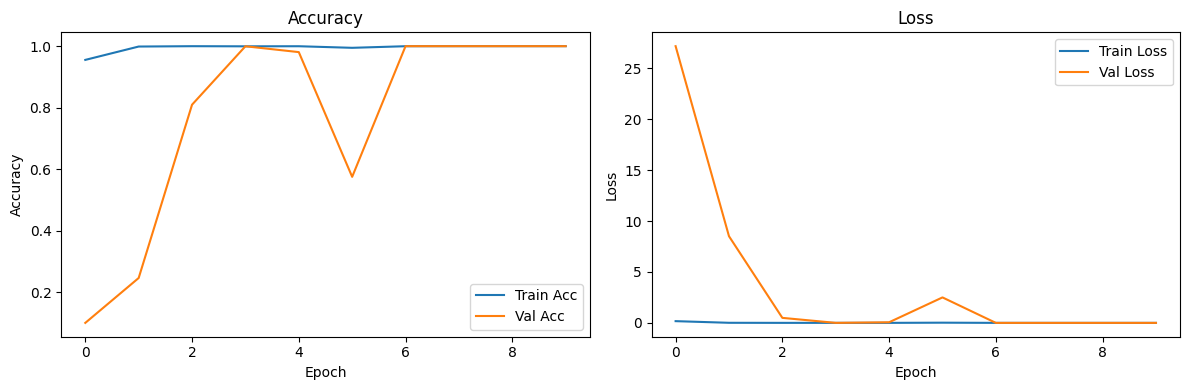

In [13]:
def plot_history(hist):
    h = hist.history
    plt.figure(figsize=(12,4))

    plt.subplot(1,2,1)
    plt.plot(h['accuracy'], label='Train Acc')
    plt.plot(h['val_accuracy'], label='Val Acc')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(h['loss'], label='Train Loss')
    plt.plot(h['val_loss'], label='Val Loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_history(history)

**Testing**

Test Accuracy: 99.97%  |  Test Loss: 0.0011

Classification Report:
               precision    recall  f1-score   support

      01_palm       1.00      1.00      1.00       300
         02_l       1.00      1.00      1.00       300
      03_fist       1.00      1.00      1.00       300
04_fist_moved       1.00      1.00      1.00       300
     05_thumb       1.00      1.00      1.00       300
     06_index       1.00      1.00      1.00       300
        07_ok       1.00      1.00      1.00       300
08_palm_moved       1.00      1.00      1.00       300
         09_c       1.00      1.00      1.00       300
      10_down       1.00      1.00      1.00       300

     accuracy                           1.00      3000
    macro avg       1.00      1.00      1.00      3000
 weighted avg       1.00      1.00      1.00      3000



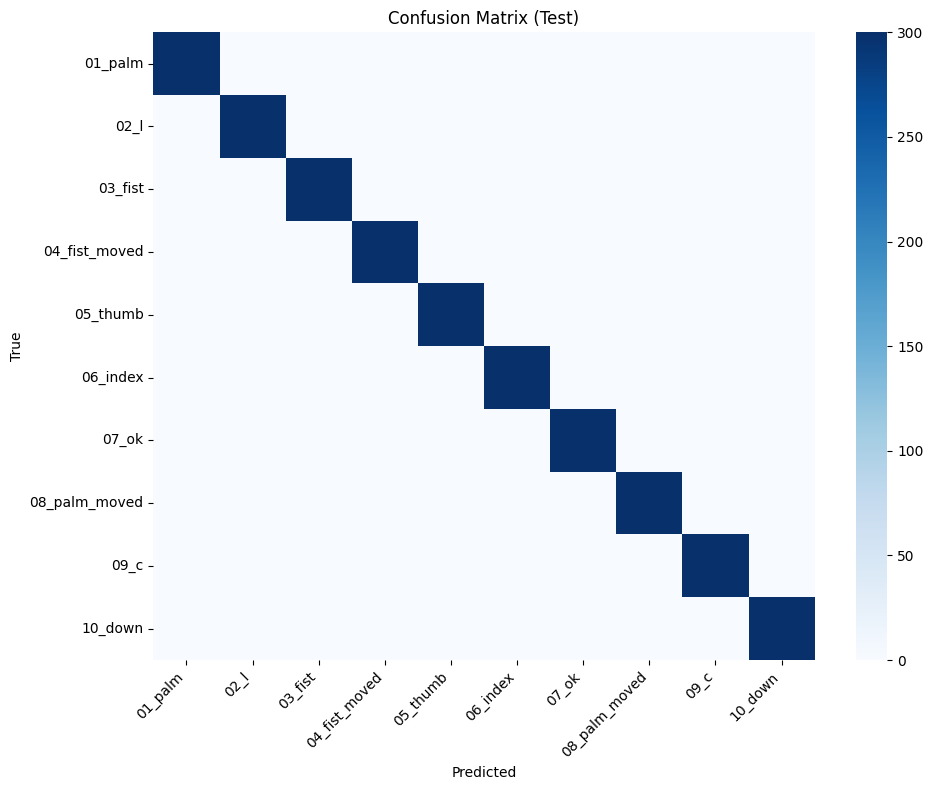

In [14]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_acc*100:.2f}%  |  Test Loss: {test_loss:.4f}")

y_pred_probs = model.predict(X_test, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=classes))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=False, cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.title("Confusion Matrix (Test)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

**Few test predictions**

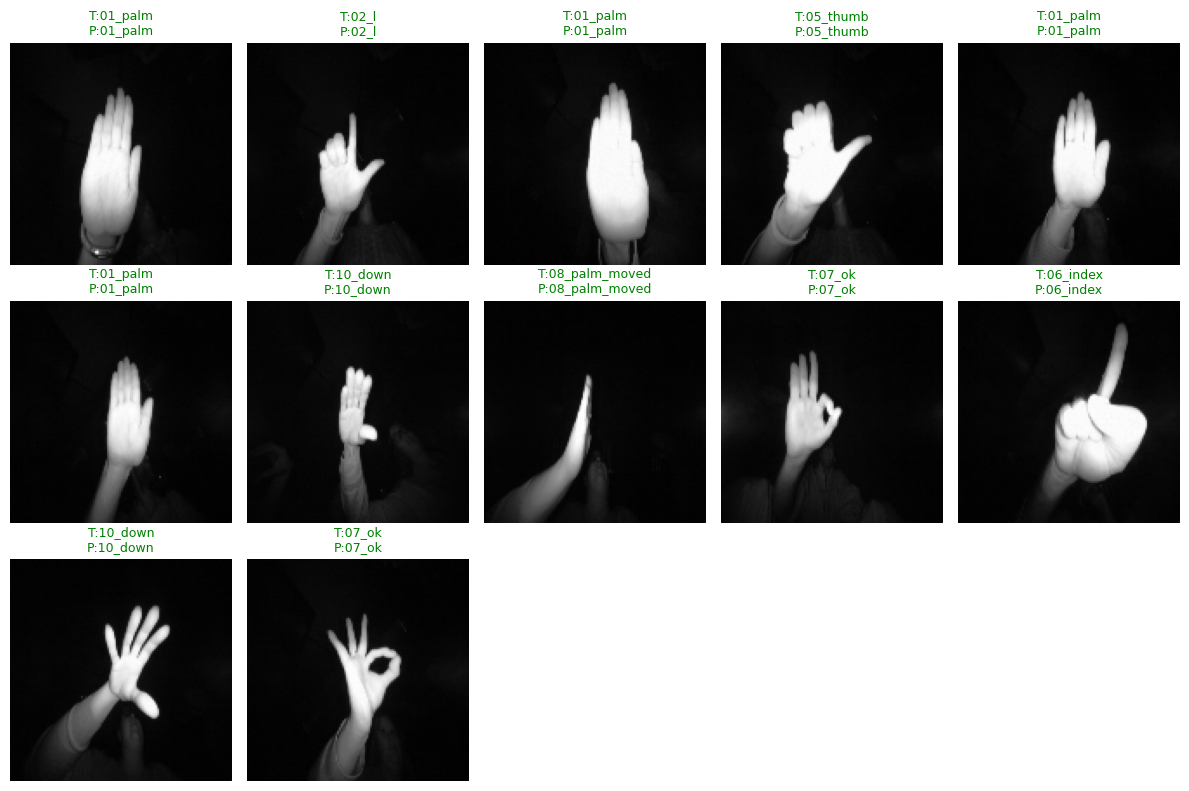

In [15]:
def show_predictions_grid(Xs, y_true, y_hat, idx2label, n=10):
    n = min(n, len(Xs))
    sel = np.random.choice(len(Xs), size=n, replace=False)
    plt.figure(figsize=(12, 8))
    for i, s in enumerate(sel):
        plt.subplot(int(np.ceil(n/5)), 5, i+1)
        img = (Xs[s].squeeze() * 255).astype(np.uint8)
        plt.imshow(img, cmap='gray')
        t = idx2label[y_true[s]]
        p = idx2label[y_hat[s]]
        color = "green" if t==p else "red"
        plt.title(f"T:{t}\nP:{p}", color=color, fontsize=9)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

show_predictions_grid(X_test, y_test, y_pred, idx2label, n=12)

**Save label map & model**

In [16]:
os.makedirs("export", exist_ok=True)
model.save("export/gesture_cnn.h5")
with open("export/labels.json", "w") as f:
    json.dump(idx2label, f)
print("Saved model to export/gesture_cnn.h5 and labels to export/labels.json")

Saved model to export/gesture_cnn.h5 and labels to export/labels.json
